In [41]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

# Data Pre-processing
import pandas as pd
from sklearn.model_selection import KFold

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import cv2
import re

# Configuration
#py.init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
samples = np.load("samples.npy")
labels = np.load("labels.npy")

In [13]:
def show(spectrogram):
    plt.imshow(spectrogram)
    plt.show()

In [14]:
#Make spectrograms
def make_spectrogram(y,sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))

In [40]:
im.shape

(217, 223, 3)

In [35]:
im.shape

(217, 223, 3)

In [21]:
sa = sa.astype('float32')

In [22]:
sa = sa.reshape(-1, 128, 87, 1)

In [81]:
# Initialising the CNN
n_labels = 4
input_size = (192, 192)
model = Sequential()
chanDim = -1
channel = 3


# Layer 1
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = (input_size[0], input_size[1], channel)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(256, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(256, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
    
# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation("softmax"))

# Compiling the CNN
EPOCHS = 100
INIT_LR = 1e-3
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])


In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 192, 192, 32)      896       
_________________________________________________________________
activation_70 (Activation)   (None, 192, 192, 32)      0         
_________________________________________________________________
batch_normalization_v1_62 (B (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_71 (Activation)   (None, 64, 64, 64)        0         
__________

In [84]:
model.load_weights("model_2d_4l.h5")

In [85]:
from sklearn.preprocessing import LabelBinarizer

In [86]:
labels = np.load("labels.npy")

In [87]:
urban = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'other',
       'drilling', 'engine_idling', 'jackhammer', 'siren', 'street_music']
for i in range(len(labels)):
    if labels[i] in urban:
        labels[i] = 'other'


lb = LabelBinarizer()
labels = lb.fit_transform(labels)

## Validation

In [88]:
def to_spec(data):
    a = make_spectrogram(data,22050)
    plt.interactive(False)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    librosa.display.specshow(librosa.power_to_db(a, ref=np.max))
    plt.savefig('temp.png', dpi=400, bbox_inches='tight',pad_inches=0)
    im = cv2.imread('temp.png')
    im = cv2.resize(im, (192, 192))

    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    return im

In [89]:
def show_wav(data):
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr = 22050)

In [145]:
mypath = "C:\\Users\\hosle\\Downloads\\shotgun-old_school-RA_The_Sun_God-1129942741.wav"
#mypath = "C:\\Users\\hosle\\Documents\\_REU2019\\extra\\260600.wav"

fire, sr = librosa.load(mypath, res_type='kaiser_fast')

In [146]:
validation = []
if (fire.size <= 44100):
    sample_slice = np.zeros(44100)
    sample_slice[0:fire.size] = fire
    validation.append(sample_slice)

for i in range(0, fire.size - 44100, 44100):
    sample_slice = fire[i : i + 44100]
    validation.append(sample_slice)
    
validation = np.array(validation)

val_im = []
for i in range(len(validation)):
    val_im.append(to_spec(validation[i]))
val_im = np.array(val_im).astype('float32')
val_im /= 255

val_pred = model.predict(val_im)
val_pred1 = lb.inverse_transform(val_pred)
print(len(val_pred1))
print("gun_shot", np.argwhere(val_pred1 == 'gun_shot').T)
print(val_pred1)

1
gun_shot [[0]]
['gun_shot']


[0. 0. 1. 0.]
gun_shot


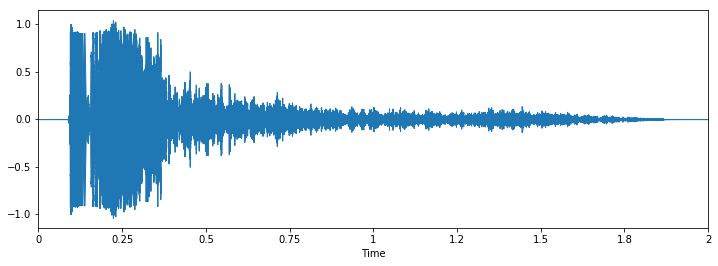

In [147]:
i = 0
print(np.round(val_pred[i, :], 3))
print(val_pred1[i])
show_wav(validation [i])

ipd.Audio(validation [i], rate=22050)